# Homework 2

Use a Chebyshev method to solve the second order ordinary differential equation

$$ u''(t) + a u'(t) + b u(t) = f(t) $$

from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.

1. Do a grid convergence study to test the accuracy of your method.
* Setting $f(t)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.

## Jed's suggestions

### Differentiating shifted/scaled Chebyshev polynomials

Let $x \in [-1,1]$ denote the reference interval.  Suppose we wish to construct a well-conditioned Chebyshev basis on some interval $t(x)$.  In this example,

$$ t(x) = (x + 1) / 2 $$

so that $t \in [0,1]$.  This transformation is invertible, yielding

$$ x(t) = 2 t - 1 .$$

Now we can transform any function $f(x)$ to $f(x(t))$ and compute its derivatives via the chain rule

$$ \frac{d f}{d t} = \frac{df}{dx} \frac{dx}{dt} .$$

In our example $dx/dt = 2$.  This process can be applied repeatedly for higher derivatives.

### Applying two initial conditions

The problem statement includes two initial conditions and no final condition.  We would like the interior equations to be satisfied everywhere but the endpoint, thus it is most natural to implement those initial conditions by overwriting the first and last rows of the matrix.

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

cond(A) = 1.042175e+05


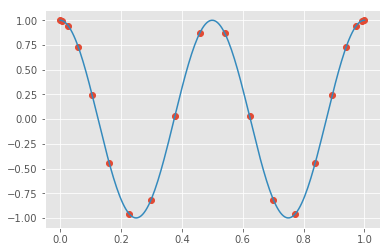

In [2]:
# We have utility functions like cosspace and chebeval defined
# in the file fdtools.py.  We would like to import it here, but
# perhaps we would like to be able to edit the file and yet keep
# using it from inside the notebook.  If we just import fdtools,
# then the file won't be reloaded unless we restarted the Jupyter
# kernel.  The %run command is much like
#
#     from fdtools import *
#
# but actually re-runs the file each time.
%run fdtools.py

def discretize(n, a, b, frhs=lambda t:0*t, u0=1, du0=0):
    """
    Discretize the initial value problem
      u'' + a*u' + b*u = frhs(t)
      u(0) = u0, u'(u) = du0
    using a Chebyshev collocation method with n points.
    """
    t = cosspace(0, 1, n)
    T = chebeval(2*t - 1)
    dxdt = 2
    T[1] *= dxdt
    T[2] *= dxdt**2
    A = T[2] + a*T[1] + b*T[0]
    A[0] = T[0][0]
    A[-1] = T[1][0]
    rhs = frhs(t)
    rhs[0] = u0
    rhs[-1] = du0
    A = A @ numpy.linalg.inv(T[0])
    return t, A, rhs

t, A, rhs = discretize(20, 0, (4*numpy.pi)**2)
print('cond(A) = {:e}'.format(numpy.linalg.cond(A)))
u = numpy.linalg.solve(A, rhs)

pyplot.plot(t, u, 'o')
tt = numpy.linspace(0, 1, 200)
pyplot.plot(tt, numpy.cos(4*numpy.pi*tt));

### Analytic solution
It turns out that $\cos(n\pi t)$ is an eigenfunction of the second derivative for every integer $n$.  We choose
\begin{gather}
  u(t) = \cos 8 \pi t \\
  u''(t) = -(8\pi)^2 u(t)
\end{gather}
so that
$$ u''(t) + \underbrace{(8 \pi)^2}_{b} u(t) = 0 $$
solves the differential equation and satisfies the requested initial conditions.
We could use this to test the solution, though it does not exercise $a \ne 0$ or $f(t) \ne 0$.

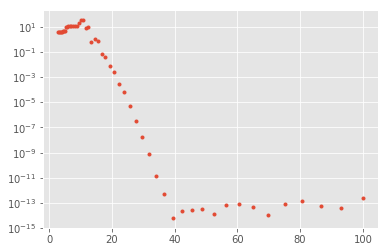

In [3]:
def analytic_error(n):
    """This is lazy by not testing 'a' or 'frhs' nonzero."""
    t, A, rhs = discretize(n, 0, (8*numpy.pi)**2)
    u = numpy.linalg.solve(A, rhs)
    return numpy.linalg.norm(u - numpy.cos(8*numpy.pi*t), numpy.inf)

ns = numpy.geomspace(3, 100)
errors = [analytic_error(n) for n in ns]
pyplot.semilogy(ns, errors, '.');

The gradual growth in the error after discretization error drops below rounding error (around $n=40$ in this example) is due to growth in the condition number of differentiation on increasingly fine discretizations.

### Manufactured solution

As a more discerning test, we can manufacture a solution.

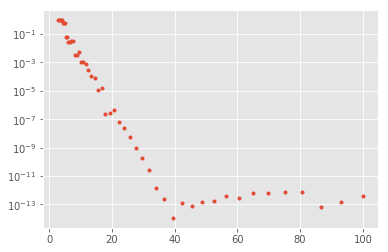

In [4]:
class exact_tanh:
    def __init__(self, k=1, x0=0):
        self.k = k
        self.x0 = x0
    def u(self, x):
        return numpy.tanh(self.k*(x - self.x0))
    def du(self, x):
        return self.k * numpy.cosh(self.k*(x - self.x0))**(-2)
    def ddu(self, x):
        return -2 * self.k**2 * numpy.tanh(self.k*(x - self.x0)) * numpy.cosh(self.k*(x - self.x0))**(-2)
    def rhs(self, a, b):
        def f(t):
            return self.ddu(t) + a*self.du(t) + b*self.u(t)
        return f

ref = exact_tanh(k=3, x0=.4) 

def mms_error(n):
    a = 1.2
    b = 3.4
    t, A, rhs = discretize(n, a, b, ref.rhs(a, b), ref.u(0), ref.du(0))
    u = numpy.linalg.solve(A, rhs)
    return numpy.linalg.norm(u - ref.u(t), numpy.inf)

ns = numpy.geomspace(3, 100)
errors = [mms_error(n) for n in ns]
pyplot.semilogy(ns, errors, '.');

## Dynamics

The differential equation

$$ u'' + a u' + b u = 0 $$

can be analyzed by inspecting the roots of the characteristic equation

$$ x^2 + a x + b = 0. $$

When the discriminant
$$ a^2 - 4 b $$
is positive, we get all-real roots, thus non-oscillatory decay.  When the discriminant is negative, we get complex roots, thus (damped when $a\ne 0$) oscillations.

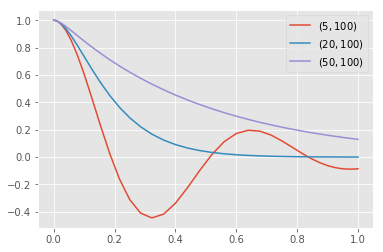

In [5]:
def plot_solution(a, b):
    t, A, rhs = discretize(40, a, b)
    pyplot.plot(t, numpy.linalg.solve(A, rhs), label='$({:g},{:g})$'.format(a, b))
    
plot_solution(5, 100)  # discriminant < 0
plot_solution(20, 100) # discriminant = 0
plot_solution(50, 100) # discriminant > 0
pyplot.legend();